### Transfer learnning on hymenoptera_data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

### Settings and Dataset

In [5]:
##########################
### SETTINGS
##########################

#RANDOM_SEED = 123
BATCH_SIZE = 4
NUM_EPOCHS = 1
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Run on:', DEVICE)

Run on: cpu


In [7]:
# From local helper files
from helper_evaluation import compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, plot_confusion_matrix
from helper_dataset import UnNormalize

In [9]:
##########################
### Hymenoptera dataset: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data
##########################
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ]),
}
#utworzenie zbioru danych
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


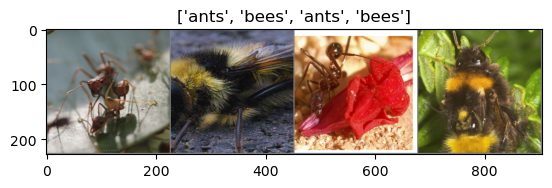

In [11]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Model

In [14]:
##########################
### MODEL
##########################

#pretrained model
model = models.vgg16(pretrained=True)
#from torchvision.models import VGG16_Weights
#model = models.vgg16(weights=VGG16_Weights.DEFAULT)
model

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the Model

In [17]:
for param in model.parameters():
    param.requires_grad = False

#Assume we want to fine-tune (train) the last 3 layers:
model.classifier[0].requires_grad = True
model.classifier[3].requires_grad = True
#replacing the last layer
model.classifier[6] = torch.nn.Linear(4096, len(class_names))

### Training as Usual

In [26]:
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max')

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=dataloaders['train'],
    valid_loader=dataloaders['val'],
    test_loader=dataloaders['val'],
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=10)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

Epoch: 001/001 | Batch 0000/0061 | Loss: 0.0000
Epoch: 001/001 | Batch 0010/0061 | Loss: 2.8378
Epoch: 001/001 | Batch 0020/0061 | Loss: 0.0000
Epoch: 001/001 | Batch 0030/0061 | Loss: 0.0001
Epoch: 001/001 | Batch 0040/0061 | Loss: 6.2955
Epoch: 001/001 | Batch 0050/0061 | Loss: 8.2301
Epoch: 001/001 | Batch 0060/0061 | Loss: 11.4667
Epoch: 001/001 | Train: 94.67% | Validation: 93.46%
Time elapsed: 4.03 min
Total Training Time: 4.03 min
Test accuracy 93.46%


NameError: name 'train_loader' is not defined

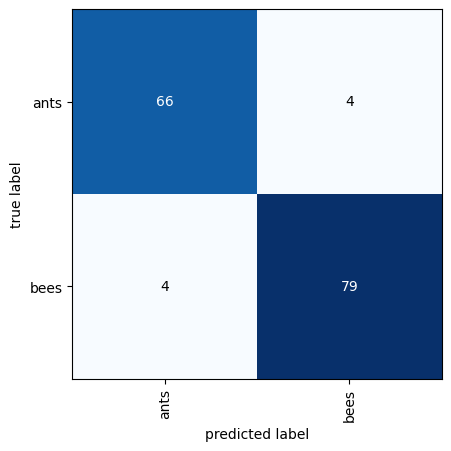

In [25]:
model.cpu()
unnormalizer = UnNormalize(mean, std)
class_dict = {0: 'ants',
              1: 'bees',}
mat = compute_confusion_matrix(model=model, data_loader=dataloaders['val'], device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())

plt.show()